In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.linalg import solve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from scipy.interpolate import CubicSpline
import patsy

In [2]:
plt.rcParams['image.cmap'] = 'icefire'
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace"
plt.style.use('ggplot')

<p style="font-weight:bold; letter-spacing: 2px; color:#000000; font-size:300%; padding: 0px; text-align:center;"> ♾️ Capturing Non-Linear Trends with Splines</p>

<p><a href="https://commons.wikimedia.org/wiki/File:Spline_interpolation.svg#/media/Datei:Spline_interpolation.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/8/8e/Spline_interpolation.svg" alt="Spline interpolation.svg" height="195" width="590"></a><br>Von <a href="https://de.wikipedia.org/wiki/Benutzer:Tam" class="extiw" title="de:Benutzer:Tam">Tam</a> - <span class="int-own-work" lang="de">Eigenes Werk</span>, Copyrighted free use, <a href="https://commons.wikimedia.org/w/index.php?curid=41211595">Link</a></p>

# About the Dataset
This dataset captures head acceleration during a simulated motorcycle accident, focusing on the relationship between the **acceleration experienced (in g)** and **time until impact (in milliseconds, ms)**. The dataset consists of two columns:

- **Acceleration (g)**: This column measures the head's acceleration during the event, where "g" represents acceleration due to gravity. High g-forces can indicate a significant impact on the head, which correlates with potential injuries.

- **Time until Impact (ms)**: This column tracks the time (in milliseconds) leading up to the impact event. It helps to understand how acceleration builds or fluctuates as the moment of collision approaches.

In a motorcycle accident, the head experiences rapid acceleration, which can result in severe injuries like concussions, brain trauma, or even fatal consequences depending on the magnitude of the force and the duration over which it occurs.

By analyzing the relationship between time and acceleration, we can gain insights into how acceleration peaks and how the head responds to sudden forces. This kind of data is often not linear in nature because of the biomechanical complexities involved. The change in acceleration leading up to the impact may follow a non-linear trajectory, making it an interesting candidate for regression models that account for these non-linearities.

# Motivation
Using spine transformation for non-linear regression allows for capturing complex relationships in data like this. The dataset is ideal for exploring these transformations because real-world phenomena such as acceleration during accidents do not usually follow simple linear trends. Thus, the spine transformation approach can help in modeling and predicting injury outcomes based on non-linear head acceleration patterns leading up to the impact.

# The Data

In [3]:
data = pd.read_csv('/kaggle/input/simulated-motorcycle-accident/Data_from_a_Simulated_Motorcycle_Accident_1163_79.csv', index_col=[0])

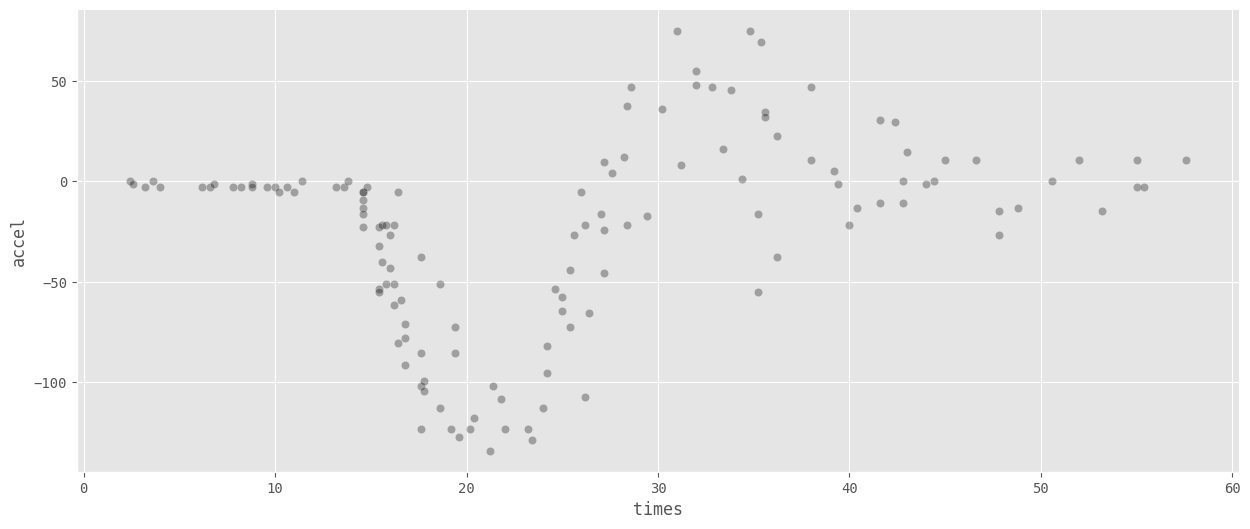

In [4]:
plt.figure(figsize=(15,6))
sns.scatterplot(x=data['times'], y=data['accel'], color='black', alpha=.3)
plt.show()

This scatterplot shows the relationship between time (in milliseconds) and head acceleration (in g). At the beginning, the acceleration is close to zero, which may represent the pre-impact phase or very minimal motion before the accident force is applied. There are several periods where the acceleration dips below zero. This suggests a deceleration or possibly a reversal of motion, potentially caused by the head reacting to forces in the opposite direction. After the big dip the data shows fluctuations with alternating positive and negative values. This likely reflects the complex forces involved during an accident, as the head experiences multiple impacts or recoils. 

# Spline Transformation
Spline transformation is a method that involve adjusting or transformating the predictor variable in a way that captures non-linear relationships between the predictor and response variable, while still allowing the model to remain flexible yet interpretable.
Spline transformation uses piecewise polynomials to model data more flexibly. Splines help in representing complex, non-linear patterns in data that cannot be captured by simple linear models. There are a few types of spline tranformations commonly used. 

## Piecewise Linear Splines
Piecewise Linear Splines are a type of regression model where the predictor space is divided into segments, and a separate linear regression is fitted within each segment. The point where the segments meet are called **knots**. 

For a single predictor variable $x$, suppose you have $K$ knots at $k_{1}, k_{2}, ... k_{t}$, then the Piecewise Linear Spline model can be written as:

$$f(x) = \beta_{0} + \beta_{1}x + \beta_{2}(x-t_{1})^{+} + \beta_{3}(x-t_{2})^{+} + ... + \beta_{K+1}(x-t_{K})^{+}$$

where
- $(x-t_{i})^{+}$ is defined as $max(0, x-t_{i})$. This term is only active when $x > t_{i}$, allowing different slopes after each knot
- $\beta_{0}$ is the intercept, and $\beta_{1}, \beta_{2}, ..., \beta_{K+1}$ are the coefficients that determine the slope in each segment

Let´s create piecewise linear splines for the dataset and visualize it. 

In [5]:
x = data['times']
y = data['accel']

### Underfitted Linear Splines

In [6]:
knots = [20, 40]
X = patsy.dmatrix("bs(x, knots=(20, 40), degree=1, include_intercept=True) - 1", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

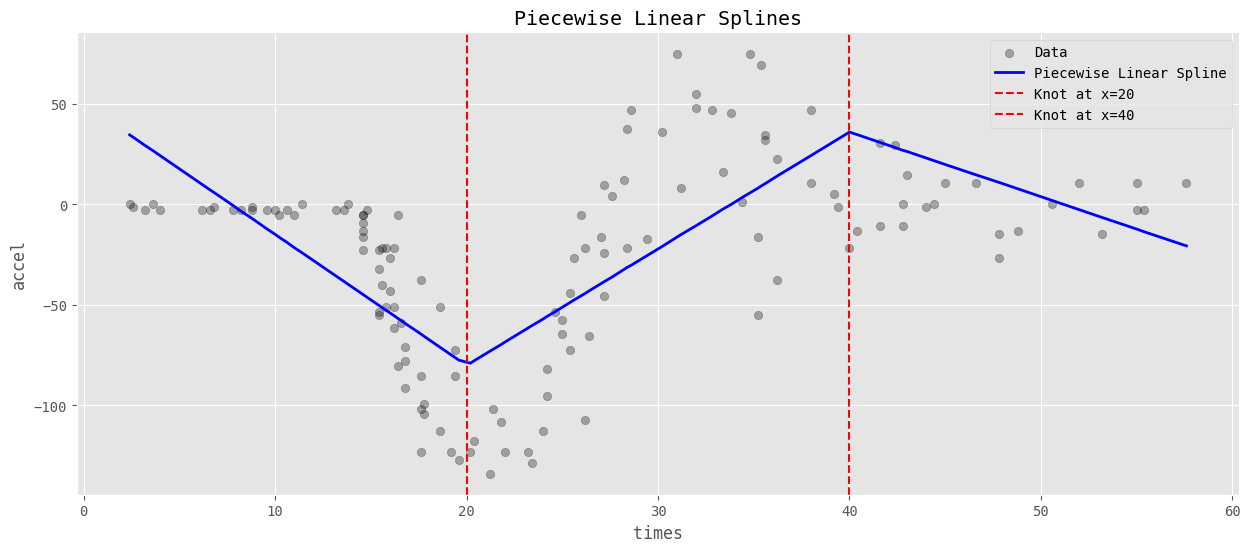

In [7]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, label='Data', alpha=.3, color='black')
plt.plot(x, y_pred, label='Piecewise Linear Spline', color='blue', linewidth=2)
plt.axvline(x=knots[0], color='red', linestyle='--', label='Knot at x=20')
plt.axvline(x=knots[1], color='red', linestyle='--', label='Knot at x=40')
plt.xlabel('times')
plt.ylabel('accel')
plt.title('Piecewise Linear Splines')
plt.legend()
plt.show()

Here we define w knots at position 20 and 40. We set the degree to 1 because we want to build a linear spline. Clearly the model underfits the data. 

### Overfitted Linear Splines

In [8]:
knots = [15, 20, 33, 40]

X = patsy.dmatrix("bs(x, knots=(15, 20, 33, 40), degree=1, include_intercept=True) - 1", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

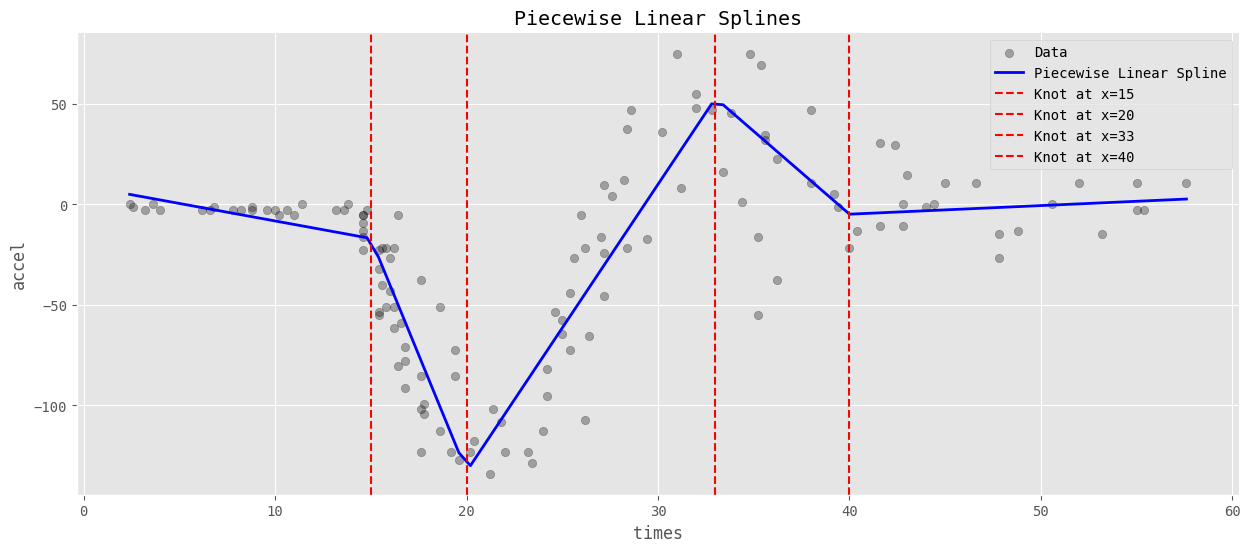

In [9]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, label='Data', alpha=.3, color='black')
plt.plot(x, y_pred, label='Piecewise Linear Spline', color='blue', linewidth=2)
plt.axvline(x=knots[0], color='red', linestyle='--', label='Knot at x=15')
plt.axvline(x=knots[1], color='red', linestyle='--', label='Knot at x=20')
plt.axvline(x=knots[2], color='red', linestyle='--', label='Knot at x=33')
plt.axvline(x=knots[3], color='red', linestyle='--', label='Knot at x=40')
plt.xlabel('times')
plt.ylabel('accel')
plt.title('Piecewise Linear Splines')
plt.legend()
plt.show()

Over and underfitting are common problems when using splines. For linear splines, there are two things to consider: Knot number/placement and smoothing/penalization. As we see above the number of knots with heavily affect over/underfitting. If there is a scientific rationale for placing knots in a certain place (for example, known changes in hormone levels at the onset of puberty), you may want to select that ahead of time. If this is not the case we can use penalization. 

Above I defined the location of the knots manually. If I do not want to to this, I can also use the `df` parameter to control the flexibility. (High `df` value will tend to overfitting the data). 

In [10]:
X = patsy.dmatrix("bs(x, degree=1, df=50, include_intercept=True) - 1", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

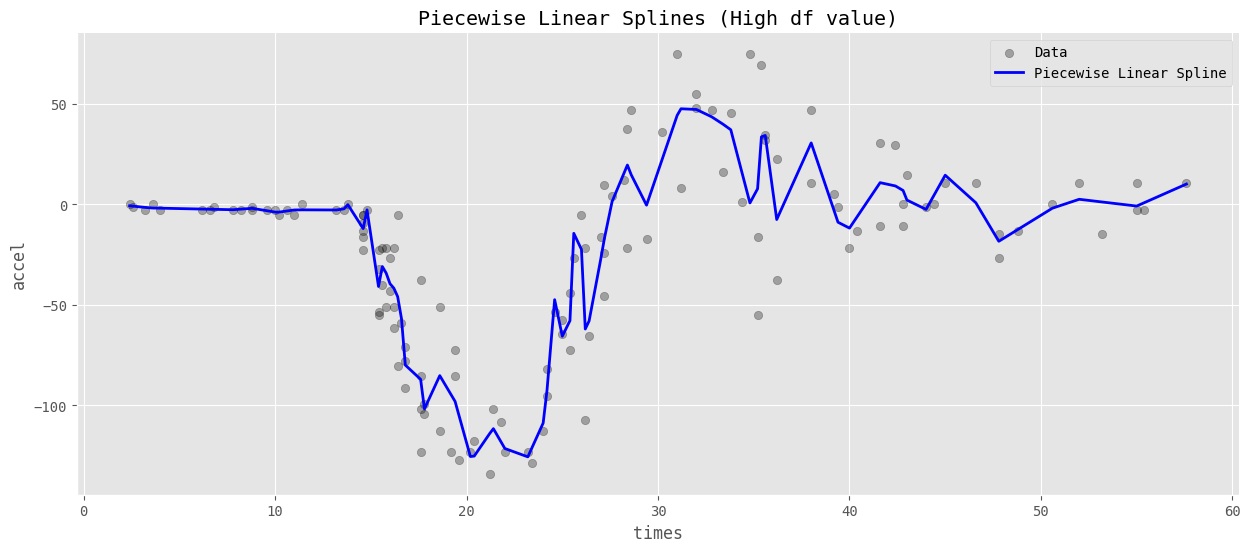

In [11]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, label='Data', alpha=.3, color='black')
plt.plot(x, y_pred, label='Piecewise Linear Spline', color='blue', linewidth=2)
plt.xlabel('times')
plt.ylabel('accel')
plt.title('Piecewise Linear Splines (High df value)')
plt.legend()
plt.show()

### Penalize Linear Splines
Linear splines are a flexible approach to modeling data where the relationship between the dependent variable (`y`) and the independent variable (`x`) is not strictly linear but can be approximated by piecewise linear functions. In this case, the domain of `x` is divided into regions by the knot points. Within each region, the relationship is modeled as a linear function, and at the knot points, the linear functions are connected to form a continuous piecewise-linear curve.

However, fitting a spline without any form of regularization can result in overfitting—especially if the number of knots is large or the data is noisy. Overfitting occurs when the spline adapts too closely to the training data, capturing noise instead of the underlying trend. This is where penalization comes into play.

The key idea behind penalized splines is to introduce a smoothing penalty into the regression procedure. This is done by adding a penalty term to the objective function that measures the roughness of the spline. The roughness is typically quantified as the sum of squared differences between adjacent spline coefficients. By minimizing a combination of the squared error (which measures how well the model fits the data) and the roughness of the spline, we can control the trade-off between fitting the data closely and keeping the spline smooth.

Mathematically, the penalized spline estimator solves the following minimization problem:

$$\hat{\beta} = argmin_{\beta} (\left\| y - X\beta \right\|^{2} + \lambda \left\| \Delta\beta \right\|^{2})$$

Where:

- $X$ is the design matrix for the linear splines
- $\beta$ is the vector of spline coefficients
- $\Delta\beta$ represents the difference between adjacent coefficients
- $\lambda$ is the regularization parameter
- $\left\| y - X\beta \right\|^{2}$ measures the fit to the data, and the term $\left\| \Delta\beta \right\|^{2}$ measures the smoothness of the splines

The regularization parameter controls trade-off between fit and smoothness:
- When $\lambda$ is small (close to zero) the model behaves similarly to an unpenalized regression fitting the data closely but potentially overfitting
- When $\lambda$ is large, the penalty term dominates, leading to a smoother spline that may underfit the data if taken to the extreme.
- An intermediate value of $\lambda$- produces a compromise between fitting the data and ensuring smoothness.

In [12]:
# Generate the design matrix for linear splines
def generate_design_matrix(degree, knot_vector, x):
    X = [x]
    for knot in knot_vector:
        X.append(np.maximum(0, x - knot))
    return np.vstack(X).T

In [13]:
# Derive the penalized coefficients for different lambda values
def penalized_spline_fit(X, y, lambda_val, D):
    return np.linalg.solve(X.T @ X + lambda_val * D, X.T @ y)

The penalty matrix $D$ I define ensures that the penalization only affects the coefficients corresponding to the spline basis functions associated with the knots. The intercept and linear term are left unpenalized, allowing the model to retain the flexibility of a linear trend, while penalizing the higher-order terms that would otherwise create wiggles in the fitted curve.

In [14]:
knot_vector = np.arange(5, 55, 5)

# Penalization matrix (adds smoothness penalty)
D = np.diag([0, 0] + [1] * len(knot_vector))
# Design matrix for penalized linear splines
X = np.column_stack([np.ones(len(x)), generate_design_matrix(degree=1, knot_vector=knot_vector, x=x)])

# Penalty values
lambda_1 = 1
lambda_9 = 9
lambda_0 = 1e-10

# Coefficients for different penalization levels
betas_1 = penalized_spline_fit(X, y, lambda_1, D)
betas_9 = penalized_spline_fit(X, y, lambda_9, D)

# For overfitting scenario (almost no penalty, with lambda = 1e-10)
betas_0 = penalized_spline_fit(X, y, lambda_0, D)

# Predicted values
yhat_1 = X @ betas_1
yhat_9 = X @ betas_9
yhat_0 = X @ betas_0  

# For overfitting scenario (no penalty, equivalent to lambda = 0)
betas_0 = np.linalg.solve(X.T @ X, X.T @ y)
yhat_0 = X @ betas_0

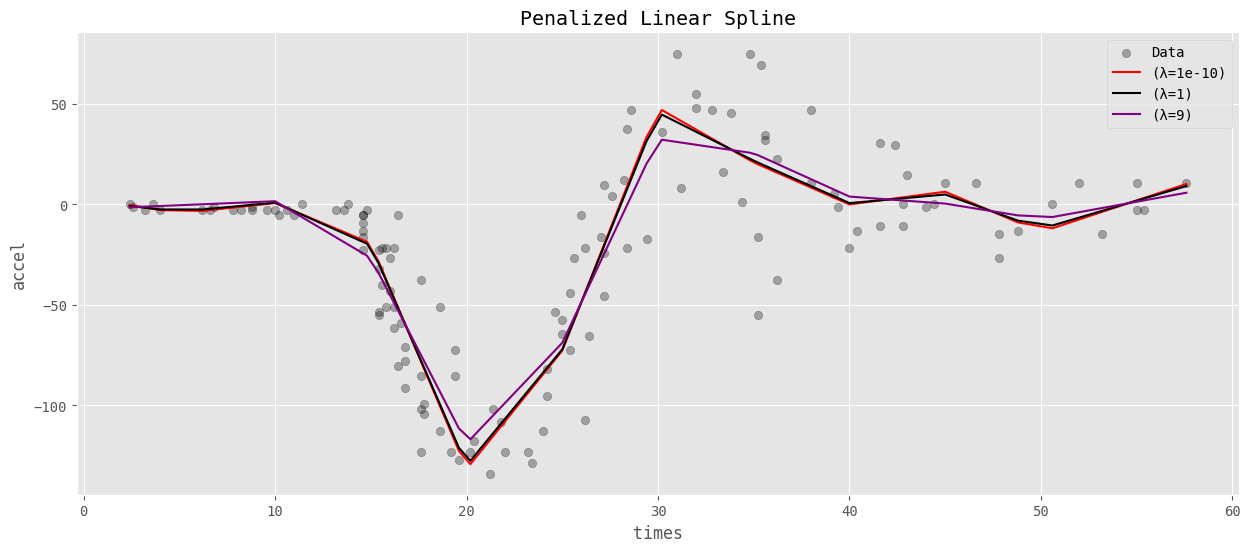

In [15]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='black', alpha=0.3, label='Data')
plt.plot(x, yhat_0, color='red', alpha=1, label=f'(λ={lambda_0})')
plt.plot(x, yhat_1, color='black', alpha=1, label=f'(λ={lambda_1})')
plt.plot(x, yhat_9, color='purple', alpha=1, label=f'(λ={lambda_9})')
plt.title("Penalized Linear Spline")
plt.xlabel('times')
plt.ylabel('accel')
plt.legend()
plt.show()

## Cubic Splines
A cubic spline is a piecewise-defined function where each segment between the knots is a cubic polynomial. These splines are widely used because they provide a smooth approximation to data, with continous first and second derivatives. In essence, cubic splines offer a balance between flexibility (to fit complex patterns) and smoothness (to avoid overfitting). But we have to be careful. The same concerns of over/underfitting are present as for the linear splines. They are addressed in the same ways as in the linear case. 

$$S(x) =
\begin{cases} 
a_1 + b_1 x + c_1 x^2 + d_1 x^3 & \text{if } x \in [t_1, t_2] \\
a_2 + b_2 x + c_2 x^2 + d_2 x^3 & \text{if } x \in [t_2, t_3] \\
\vdots \\
a_k + b_k x + c_k x^2 + d_k x^3 & \text{if } x \in [t_{k-1}, t_k] \\
\end{cases}$$

- Each $a_{i}, b_{i}, c_{i}, d_{i}$ are the coefficients of the cubic polynomials for each interval
- The first and second derivatives are continous at the knots to ensure smooth transitions

### Underfitted Cubic Splines

In [16]:
X = patsy.dmatrix("bs(x, knots=(15, 40), degree=3, include_intercept=True)", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

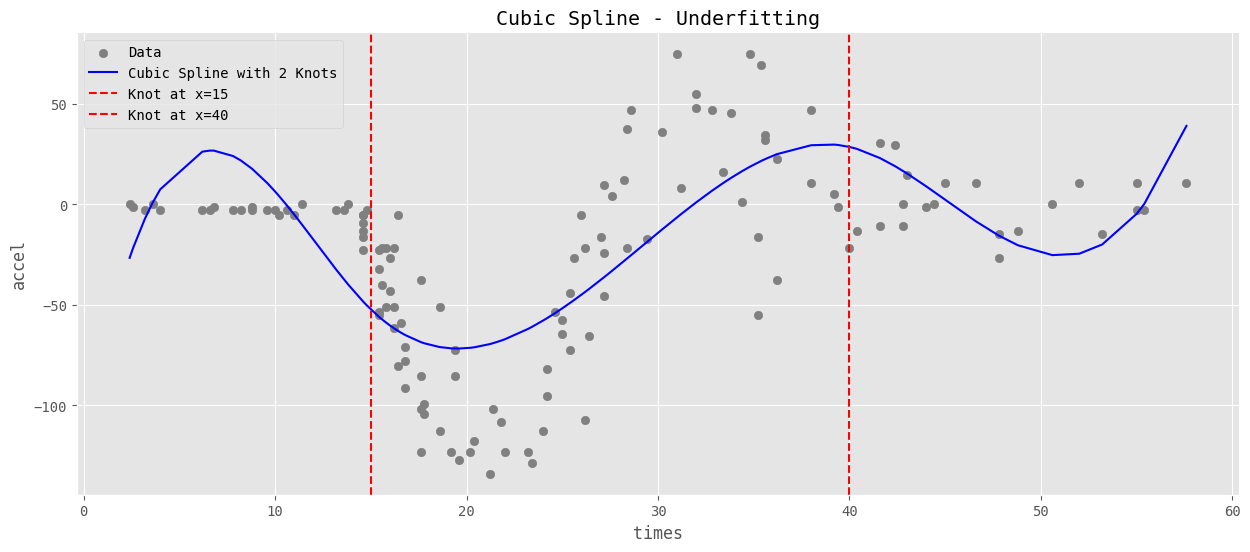

In [17]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data')
plt.plot(x, y_pred, color='blue', label='Cubic Spline with 2 Knots')
plt.axvline(x=15, color='red', linestyle='--', label='Knot at x=15')
plt.axvline(x=40, color='red', linestyle='--', label='Knot at x=40')
plt.title('Cubic Spline - Underfitting')
plt.xlabel('times')
plt.ylabel('accel')
plt.legend()
plt.show()

Here we defined just 2 knots with a degree of 2. This combination will lead to underfitting. 

### Overfitted Cubic Splines

In [18]:
X = patsy.dmatrix("bs(x, knots=np.arange(2.5, 57.5, 0.5), degree=3, include_intercept=True)", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

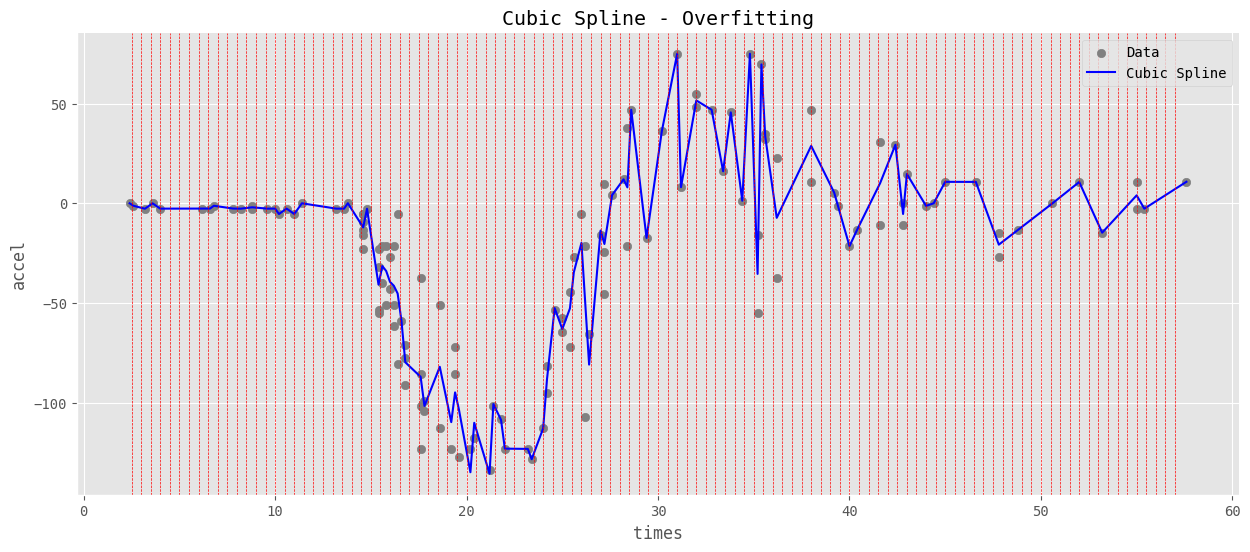

In [19]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data')
plt.plot(x, y_pred, color='blue', label='Cubic Spline')
for vline in np.arange(2.5, 57.5, 0.5):
    plt.axvline(x=vline, color='red', linestyle='--', linewidth=0.5)
plt.title('Cubic Spline - Overfitting')
plt.xlabel('times')
plt.ylabel('accel')
plt.legend()
plt.show()

Here we created a lot of knots with degree 2 which will lead to overfitting.

In [20]:
X = patsy.dmatrix("bs(x, degree=3, df=50, include_intercept=True)", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

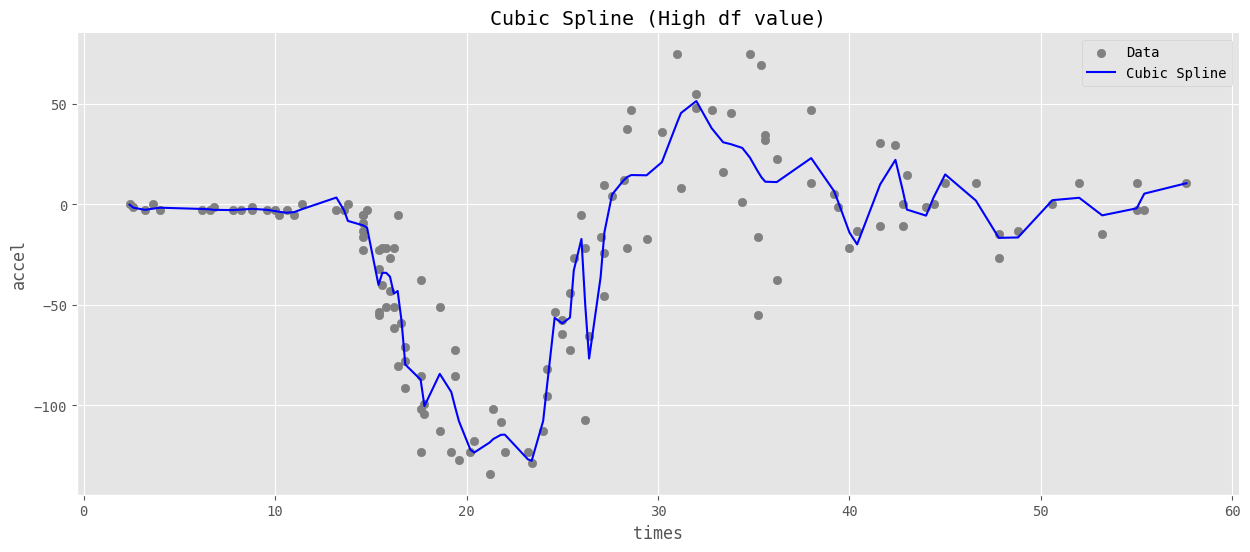

In [21]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data')
plt.plot(x, y_pred, color='blue', label='Cubic Spline')
plt.title('Cubic Spline (High df value)')
plt.xlabel('times')
plt.ylabel('accel')
plt.legend()
plt.show()

Same as earlier, high `df` values will lead to overfitting the data. 

### Penalized Cubic Splines
Penalization in cubic splines works similarly to linear splines but with a key difference: cubic splines are more flexible because they can adapt to curvature in the data more effectively. However, this increased flexibility also means they are more prone to overfitting, particularly when many knots are used or when the data is noisy.

To mitigate overfitting, we introduce a smoothness penalty on the spline coefficients. The penalized spline approach for cubic splines involves minimizing the following objective function:

$$\hat{\beta} = argmin_{\beta} (\left\| y - X\beta \right\|^{2} + \lambda \left\| \Delta^{2}\beta \right\|^{2})$$

Where:
- $\left\| y - X\beta \right\|^{2}$ is the sum of squared residuals, which measures how well the spline fits in the data
- $\left\| \Delta^{2}\beta \right\|^{2}$ is the penalty term that measures the roughness of the spline. In the case of cubic splines, this term often penalizes the second differences of adjacent coefficients, reflecting the curvature or "wiggliness" of the spline.
- $\lambda$ is the regularization parameter that controls the trade-off between goodness of fit and smoothness.

The main difference between the penalization for cubic and linear splines is in the nature of the penalization. While linear splines penalize jumps in the first derivative (i.e., changes in slope), cubic splines penalize jumps in the second derivative (i.e., changes in curvature). As a result, the penalization in cubic splines smooths out the curvature of the spline, rather than just smoothing out changes in slope as in linear splines.

In [22]:
def penalized_spline_fit(X, y, lamb, D):
    # Penalized regression coefficients
    XtX = X.T @ X
    XtY = X.T @ y
    penalty = lamb * D
    # Add a small regularization term to avoid singularity (ridge-like penalty)
    regularization_term = np.eye(XtX.shape[0]) * 1e-10
    return solve(XtX + penalty + regularization_term, XtY)

In [23]:
def generate_design_matrix(degree, knot_vector, x):
    # Create the spline basis using patsy with specified knots and degree
    formula = f"bs(x, knots={list(knot_vector)}, degree={degree}, include_intercept=True)"
    return patsy.dmatrix(formula, {"x": x})

In [24]:
knot_vector = np.arange(2.5, 57.5, 5)

# Generate the design matrix for cubic splines
X = np.column_stack([np.ones(len(x)), generate_design_matrix(degree=3, knot_vector=knot_vector, x=x)])

# The number of coefficients is the number of columns in X
n_coefs = X.shape[1]

# Penalization matrix (smoothness penalty for cubic splines)
# The size of D must match the number of columns in X
D = np.diag([0] * 4 + [1] * (n_coefs - 4))  # Cubic spline, so we use 4 leading zeros

# Penalty values (tuning parameters for penalization)
lambda_1 = 1
lambda_9 = 9
lambda_0 = 1e-10  # Very small penalty for overfitting scenario

# Fit the model with different levels of penalization
betas_1 = penalized_spline_fit(X, y, lambda_1, D)
betas_9 = penalized_spline_fit(X, y, lambda_9, D)
betas_0 = penalized_spline_fit(X, y, lambda_0, D)

# Predicted values for different penalization levels
yhat_1 = X @ betas_1
yhat_9 = X @ betas_9

# For comparison: No penalty scenario (lambda = 0)
betas_no_penalty = np.linalg.solve(X.T @ X + np.eye(X.shape[1]) * 1e-10, X.T @ y)
yhat_no_penalty = X @ betas_no_penalty

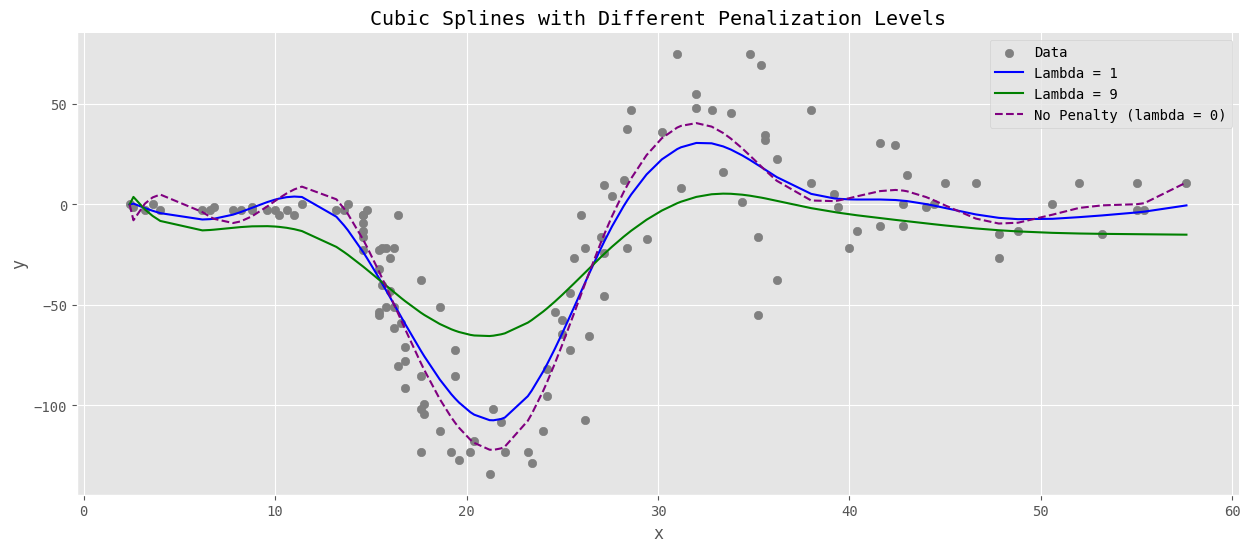

In [25]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data')
plt.plot(x, yhat_1, color='blue', label='Lambda = 1')
plt.plot(x, yhat_9, color='green', label='Lambda = 9')
plt.plot(x, yhat_no_penalty, color='purple', linestyle='--', label='No Penalty (lambda = 0)')
plt.title('Cubic Splines with Different Penalization Levels')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Natural Splines
Natural splines are a specific type of cubic spline that adds additional boundary constraints to ensure smoother behavior at the ends of the data range. Specifically, natural splines enforce that the second derivative of the spline is zero at the boundary knots. This helps prevent large oscillations at the boundaries, which is a common problem with standard cubic splines.

Natural splines are still piecewise cubic polynomials, but with the additional constraint that the second derivative of the spline at the boundary knots (both at start and end) is zero. 

$$
S(x) =
\begin{cases} 
a_1 + b_1 x + c_1 x^2 + d_1 x^3 & \text{if } x \in [t_1, t_2] \\
a_2 + b_2 x + c_2 x^2 + d_2 x^3 & \text{if } x \in [t_2, t_3] \\
\vdots \\
a_k + b_k x + c_k x^2 + d_k x^3 & \text{if } x \in [t_{k-1}, t_k] \\
\end{cases}
$$

However, at the boundaries (first and last knots), the second derivative of the spline is set to 0. 

In [26]:
knots = [15, 20, 33, 40]
X_cr = patsy.dmatrix("cr(x, knots=(15, 20, 33, 40))", {"x": x})
X_bs = patsy.dmatrix("bs(x, knots=(15, 20, 33, 40), degree=3, include_intercept=True)", {"x": x})

model_cr = LinearRegression()
model_cr.fit(X_cr, y)
y_pred_cr = model_cr.predict(X_cr)

model_bs = LinearRegression()
model_bs.fit(X_bs, y)
y_pred_bs = model_bs.predict(X_bs)

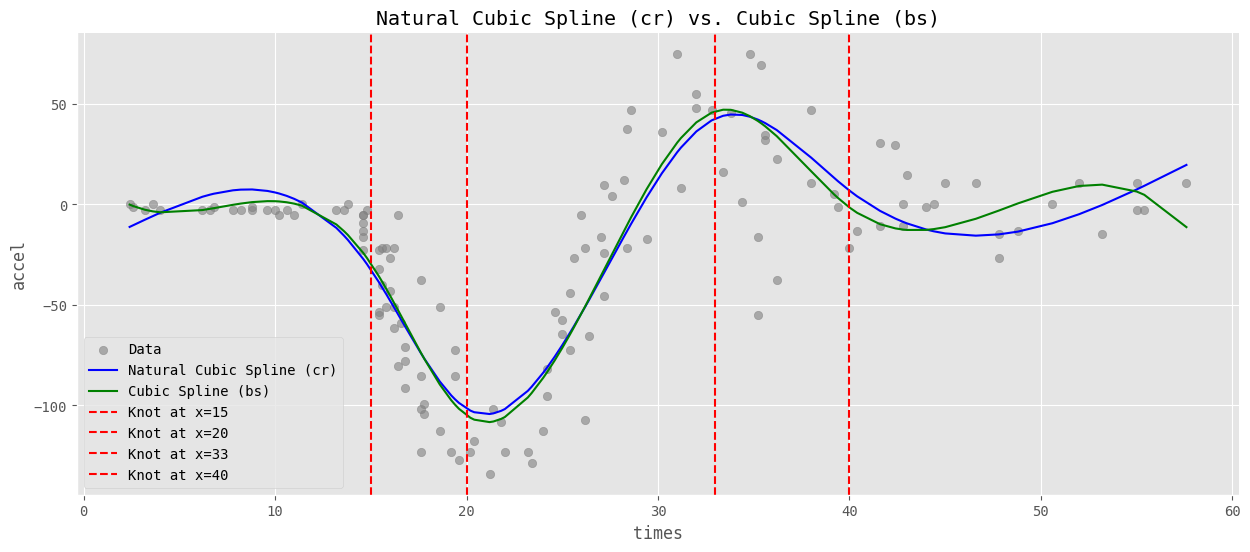

In [27]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data', alpha=0.6)
plt.plot(x, y_pred_cr, color='blue', label='Natural Cubic Spline (cr)')
plt.plot(x, y_pred_bs, color='green', label='Cubic Spline (bs)')
for knot in knots:
    plt.axvline(x=knot, color='red', linestyle='--', label=f'Knot at x={knot}')
plt.title('Natural Cubic Spline (cr) vs. Cubic Spline (bs)')
plt.xlabel('times')
plt.ylabel('accel')
plt.legend(loc='best')
plt.show()

## B-Splines
B-Splines, also called basis splines provide a more compact representation of splines. They are piecewise polynomials but use a basis representation, which can improve computational efficiency. 
Remember the design matrix above?

```python
X = patsy.dmatrix("bs(x, knots=np.arange(2.5, 57.5, 0.5), degree=3, include_intercept=True)", {"x": x})
```

Patsy cannot directly define a simple normal linear or cubic spline. The library always works with a B-spline basis function. So we accidentally created a B-spline and not a cubic spline?

Yes and no. A cubic spline is essentially a B-spline of degree 3. When you use cubic splines in many libraries you often use a B-spline uder the hood. When you create a cubic spline, you´re effectively constructing a spline with degree 3 basis functions, which is exactly what a cubic B-spline is. The difference is often in the terminology:
- **Cubic Spline:** Refers to the visual result - a smooth curve made up of cubic polynomial pieces. 
- **Cubic B-Spline:** Refers to the mathematical construction - it uses basis functions of degree 3 to build the spline. 

So what exacly is a **basis function**?

Imagine you have a set of Lego pieces (the basis functions), and you want to build a bigger, more flexible structure (the curve). Each Lego piece is a small, simple shape on its own. But when you put these pieces together in different ways, you can create something much more complex and useful.

In B-splines, the basis functions are small, simple mathematical shapes (like curves), and each one covers a specific part of the data range. When you add these basis functions together (by multiplying them with coefficients), you create a smooth, flexible curve that can fit the data you're modeling.

Each basis function has influence over a small section of the curve, and the way they overlap and combine controls how the final curve behaves—whether it’s smooth, sharp, or more flexible.

So, a basis function is just a small, simple piece of the whole curve, and by combining many of them, you can shape the curve to fit the data in a smooth and flexible way.

In [28]:
X = patsy.dmatrix("bs(x, degree=20, df=50, include_intercept=True)", {"x": x})

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

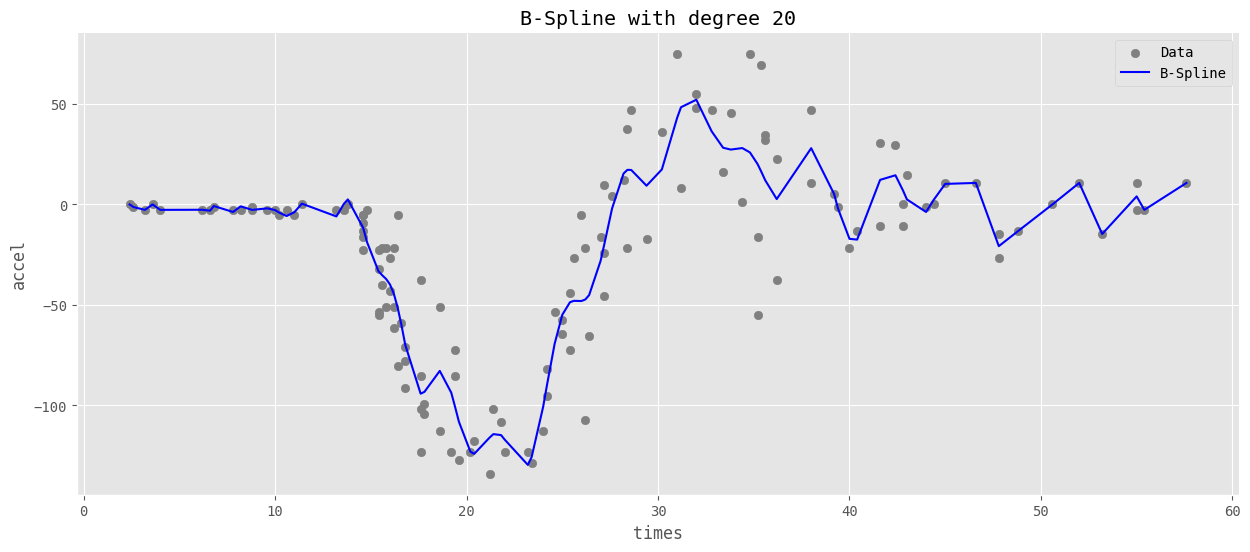

In [29]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, color='gray', label='Data')
plt.plot(x, y_pred, color='blue', label='B-Spline')
plt.title('B-Spline with degree 20')
plt.xlabel('times')
plt.ylabel('accel')
plt.legend()
plt.show()

Here I created a B-spline with degree 20. The `df=50` controls the flexibiliy of the spline without explicitly adding knots. Obviously the model is overfitted. We can use KFold cross validation to find the best degree. 

Let's do a rudimentary cross validation. 

In [30]:
def cross_validate_spline(degree, x, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_list = []

    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

        df = degree + 1
        X_train_spline = patsy.dmatrix(f"bs(x_train, degree={degree}, df={df}, include_intercept=True)", {"x_train": x_train})
        X_test_spline = patsy.dmatrix(f"bs(x_test, degree={degree}, df={df}, include_intercept=True)", {"x_test": x_test})

        model = LinearRegression()
        model.fit(X_train_spline, y_train)
        y_pred = model.predict(X_test_spline)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    return np.mean(mse_list)

In [31]:
def plot_spline_fit(degree, x, y):
    df = degree + 1
    X_spline = patsy.dmatrix(f"bs(x, degree={degree}, df={df}, include_intercept=True)", {"x": x})
    
    model = LinearRegression()
    model.fit(X_spline, y)
    y_pred = model.predict(X_spline)
    
    plt.scatter(x,y, color='gray')
    plt.plot(x, y_pred, label=f'B-Spline Degree {degree}')
    plt.title(f'B-Splines with different degrees')
    plt.xlabel('times')
    plt.ylabel('accel')
    plt.legend()

Degree: 1, MSE: 2138.852808711102
Degree: 2, MSE: 2288.6800508241754
Degree: 3, MSE: 2499.6795374782096
Degree: 5, MSE: 2894.2200027472527
Degree: 6, MSE: 2951.9260054945053
Degree: 7, MSE: 2924.4907857142857
Degree: 8, MSE: 3134.1901813186814
Degree: 9, MSE: 3106.602049450549


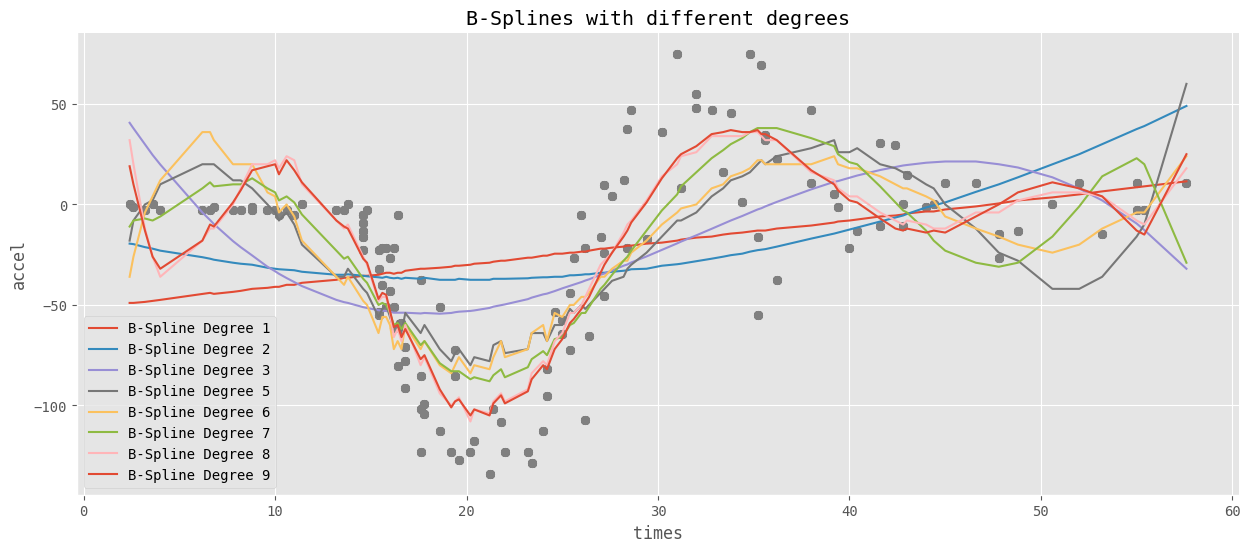

In [32]:
degrees = [1, 2, 3, 5, 6, 7, 8, 9]
mse_scores = []

plt.figure(figsize=(15, 6))

for degree in degrees:
    mse = cross_validate_spline(degree, x.values, y.values)
    mse_scores.append(mse)
    plot_spline_fit(degree, x, y)
    print(f"Degree: {degree}, MSE: {mse}")
plt.show()

# Takeaways
- Splines provide a powerful tool for non-linear regression, offering a balance between flexibility and smoothness.
- B-splines allow for smooth, continuous curve fitting without the oscillations of high-degree polynomials.
- Careful selection of degree and knots is crucial for balancing the model’s complexity, with cross-validation being a reliable method for optimizing these parameters.
- Splines prevent overfitting better than standard polynomials, and penalized splines can further control excessive flexibility, leading to smoother models.